In [1]:
import os 
import numpy as np 
import scipy.stats as ss
import nibabel as nib 
import hcp_utils as hcp 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns 
import seaborn.objects as so 
from surfplot import Plot

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
dir_path = r'/Users/weiwei/BaiduCloud/Work/Paris/HSV/Revised/data'
rgba_mv = np.load(os.path.join(dir_path, 'rgba_mv_rmRS_167.npy'))
rgba_rs = np.load(os.path.join(dir_path, 'rgba_7t_rs.npy'))
# rgba_3t = np.load(os.path.join(dir_path, 'rgba_3t_rs.npy'))
import v_model_hsv as vmod 
th_ind_mv, rd_ind_mv, th_grp_mv, rd_grp_mv, color_mv = vmod.v_hsv_model_rgba_indiv(rgba_mv)
th_ind_rs, rd_ind_rs, th_grp_rs, rd_grp_rs, color_rs = vmod.v_hsv_model_rgba_indiv(rgba_rs)
# th_ind_3t, rd_ind_3t, th_grp_3t, rd_grp_3t, color_3t = vmod.v_hsv_model_rgba_indiv(rgba_3t)

In [3]:
dir_cloud = '/Users/weiwei/BaiduCloud'
dir_surf = dir_cloud + '/Work/Paris/HSV/Surfs'
slh = dir_surf + '/S1200.L.inflated_MSMAll.32k_fs_LR.surf.gii'
srh = dir_surf + '/S1200.R.inflated_MSMAll.32k_fs_LR.surf.gii'
lab_l = nib.load(dir_surf + '/fsLR.32k.L.label.gii').agg_data()
lab_r = nib.load(dir_surf + '/fsLR.32k.R.label.gii').agg_data()
labs  = np.concatenate((lab_l, lab_r))
parc   = hcp.mmp.map_all[hcp.struct.cortex]
yeo7   = hcp.yeo7.map_all[hcp.struct.cortex]
from nilearn import surface
slh_inf = surface.load_surf_mesh(slh)
srh_inf = surface.load_surf_mesh(srh)

In [3]:
import matplotlib as mpl

def v_surf_plot_32k(surf_lh, surf_rh, face_colors_lh, face_colors_rh, fig_size, 
                    layout_lr, layout_azim, layout_elev,
                    surf_alpha, bg_alpha, bg_darkness):
    
    bg_lh = hcp.mesh.sulc_left
    bg_rh = hcp.mesh.sulc_right

    coordL, facesL = surf_lh
    coordR, facesR = surf_rh

    facesL = np.array(facesL, dtype=int)
    facesR = np.array(facesR, dtype=int)

    limits = [np.min((coordL.min(), coordR.min())), np.max((coordL.max(), coordR.max()))]

    # set colors
    face_colors_lh[:,3] = surf_alpha
    face_colors_rh[:,3] = surf_alpha

    bg_faces_lh = np.mean(bg_lh.copy()[facesL], axis=1)
    bg_vmin_lh, bg_vmax_lh = np.min(bg_faces_lh), np.max(bg_faces_lh)
    if (bg_vmin_lh < 0 or bg_vmax_lh > 1):
        bg_norm_lh = mpl.colors.Normalize(vmin=bg_vmin_lh, vmax=bg_vmax_lh)
        bg_faces_lh = bg_norm_lh(bg_faces_lh)
    # bg_faces_lh *= bg_darkness 
    bg_faces_color_lh = plt.cm.gray_r(bg_faces_lh)
    bg_faces_color_lh[:, :3] *= bg_darkness
    bg_faces_color_lh[:,  3] = bg_alpha

    bg_faces_rh = np.mean(bg_rh.copy()[facesR], axis=1)
    bg_vmin_rh, bg_vmax_rh = np.min(bg_faces_rh), np.max(bg_faces_rh)
    if (bg_vmin_rh < 0 or bg_vmax_rh > 1):
        bg_norm_rh = mpl.colors.Normalize(vmin=bg_vmin_rh, vmax=bg_vmax_rh)
        bg_faces_rh = bg_norm_rh(bg_faces_rh)
    # bg_faces_rh *= bg_darkness 
    bg_faces_color_rh = plt.cm.gray_r(bg_faces_rh)
    bg_faces_color_rh[:, :3] *= bg_darkness
    bg_faces_color_rh[:,  3] = bg_alpha

    mix_lh = np.empty_like(face_colors_lh)
    mix_lh[:, 3] = 1 - (1 - face_colors_lh[:,3]) * (1 - bg_faces_color_lh[:,3])
    for color_index in range(0, 3):
        mix_lh[:, color_index] = (
            face_colors_lh[:, color_index] * face_colors_lh[:, 3]
            + bg_faces_color_lh[:, color_index] * bg_faces_color_lh[:, 3] * (1 - face_colors_lh[:, 3])
        ) / mix_lh[:, 3]

    mix_rh = np.empty_like(face_colors_rh)
    mix_rh[:, 3] = 1 - (1 - face_colors_rh[:,3]) * (1 - bg_faces_color_rh[:,3])
    for color_index in range(0, 3):
        mix_rh[:, color_index] = (
            face_colors_rh[:, color_index] * face_colors_rh[:, 3]
            + bg_faces_color_rh[:, color_index] * bg_faces_color_rh[:, 3] * (1 - face_colors_rh[:, 3])
        ) / mix_rh[:, 3]

    
    # masking figure
    fig = plt.figure(figsize=fig_size)
    num_subplot = len(layout_lr)

    for i in range(num_subplot):
        axs = fig.add_subplot(1,num_subplot,i+1, projection='3d')
        axs.grid(False)
        axs.set_xlim(*limits)
        axs.set_ylim(*limits)
        axs.set_box_aspect(aspect=(0.5, 1.3, 0.9))
        axs.view_init(elev=layout_elev[i], azim=layout_azim[i])
        axs.set_axis_off()

        if layout_lr[i] == 'lh':
            coords = coordL.copy()
            faces  = facesL.copy()
            faces_color = mix_lh.copy()
        else:
            coords = coordR.copy()
            faces  = facesR.copy()
            faces_color = mix_rh.copy() 

        p3d = axs.plot_trisurf(coords[:, 0], coords[:, 1], coords[:, 2],
                            triangles=faces, linewidth=0., 
                            antialiased=False)
        p3d.set_facecolors(faces_color)

    fig.tight_layout()

    return fig 

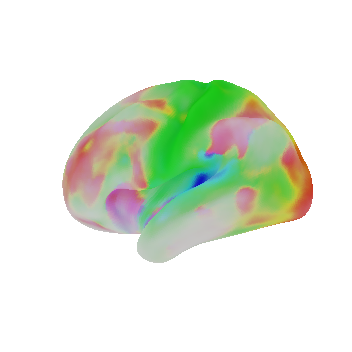

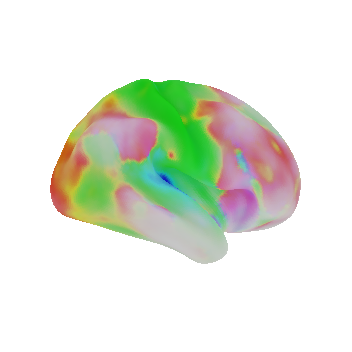

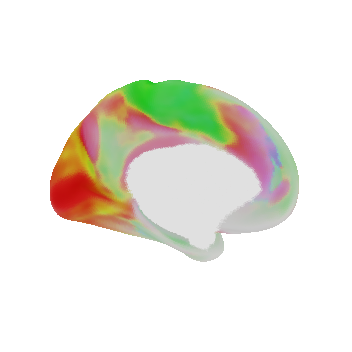

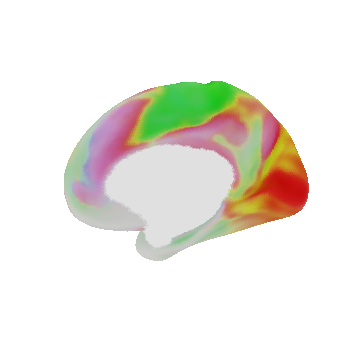

In [6]:
color_surf_mv = np.ones((32492*2, 3))
color_surf_mv[labs!=0,:] = color_rs
color_surf_mv_lh = color_surf_mv[:32492,:]
color_surf_mv_rh = color_surf_mv[32492:,:]

color_faces_mv_lh = np.mean(color_surf_mv_lh[hcp.mesh.inflated_left[1]], axis=1)
color_faces_mv_rh = np.mean(color_surf_mv_rh[hcp.mesh.inflated_right[1]], axis=1)

color_faces_mv_L = np.ones((color_faces_mv_lh.shape[0], 4))
color_faces_mv_L[:,:3] = color_faces_mv_lh

color_faces_mv_R = np.ones((color_faces_mv_rh.shape[0], 4))
color_faces_mv_R[:,:3] = color_faces_mv_rh

f1=v_surf_plot_32k(surf_lh=slh_inf, surf_rh=srh_inf, 
                face_colors_lh=color_faces_mv_L.copy(), face_colors_rh=color_faces_mv_R.copy(), fig_size=(5,5), 
                layout_lr=['lh'], layout_azim=[180], layout_elev=[0],
                surf_alpha=0.8, bg_alpha=0.9, bg_darkness=0.6)
f2=v_surf_plot_32k(surf_lh=slh_inf, surf_rh=srh_inf, 
                face_colors_lh=color_faces_mv_L.copy(), face_colors_rh=color_faces_mv_R.copy(), fig_size=(5,5), 
                layout_lr=['rh'], layout_azim=[0], layout_elev=[0],
                surf_alpha=0.8, bg_alpha=0.9, bg_darkness=0.6)
f3=v_surf_plot_32k(surf_lh=slh_inf, surf_rh=srh_inf, 
                face_colors_lh=color_faces_mv_L.copy(), face_colors_rh=color_faces_mv_R.copy(), fig_size=(5,5), 
                layout_lr=['lh'], layout_azim=[0], layout_elev=[0],
                surf_alpha=0.8, bg_alpha=0.9, bg_darkness=0.6)
f4=v_surf_plot_32k(surf_lh=slh_inf, surf_rh=srh_inf, 
                face_colors_lh=color_faces_mv_L.copy(), face_colors_rh=color_faces_mv_R.copy(), fig_size=(5,5), 
                layout_lr=['rh'], layout_azim=[180], layout_elev=[0],
                surf_alpha=0.8, bg_alpha=0.9, bg_darkness=0.6)
f1.savefig('/Users/weiwei/BaiduCloud/Work/Paris/HSV/Revised/figures/plot/f02/surf_7t_rs_lateral_lh.png', transparent='True',dpi=1200)
f2.savefig('/Users/weiwei/BaiduCloud/Work/Paris/HSV/Revised/figures/plot/f02/surf_7t_rs_lateral_rh.png', transparent='True',dpi=1200)
f3.savefig('/Users/weiwei/BaiduCloud/Work/Paris/HSV/Revised/figures/plot/f02/surf_7t_rs_medial_lh.png', transparent='True',dpi=1200)
f4.savefig('/Users/weiwei/BaiduCloud/Work/Paris/HSV/Revised/figures/plot/f02/surf_7t_rs_medial_rh.png', transparent='True',dpi=1200)

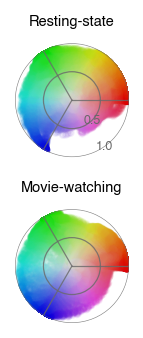

In [67]:
from matplotlib.gridspec import GridSpec
plt.rcParams["font.family"] = "Helvetica"

cm = 1/2.54
fig=plt.figure(figsize=(9*cm, 6*cm), dpi=150, facecolor='white')
gs = GridSpec(2, 1, figure=fig)

axs = [None] * 2
axs[0] = fig.add_subplot(gs[0,0], projection='polar')
axs[1] = fig.add_subplot(gs[1,0], projection='polar')

axs[0].scatter(th_grp_rs, rd_grp_rs, c=color_rs, alpha=.1, s=10)
axs[1].scatter(th_grp_mv, rd_grp_mv, c=color_mv, alpha=.1, s=10)

for i in range(2):
    axs[i].set_ylim([0,1])
    axs[i].set_yticks([0.5, 1])
    axs[i].set_xticks([0/360*2*np.pi,120/360*2*np.pi,240/360*2*np.pi])
    if i==0:
        axs[i].set_xticklabels(labels=['','',''], fontdict={'fontsize':6, "color":'dimgrey'})
        axs[i].set_yticklabels(labels=['0.5', '1.0'], fontdict={'fontsize':6, "color":'dimgrey'})
        # axs[i].xaxis.set_tick_params(pad=-1)
    else:
        axs[i].set_xticklabels(labels=['','',''], fontdict={'fontsize':6, "color":'dimgrey'})
        axs[i].set_yticklabels(labels=['', ''], fontdict={'fontsize':6, "color":'dimgrey'})
    axs[i].set_rlabel_position(-65.5)
    axs[i].tick_params(axis='x', which='major', pad=-4.5)
    axs[i].grid(linewidth=0.6, color='dimgrey', alpha=.8)
    axs[i].spines['polar'].set_visible(False)

axs[0].set_title('Resting-state', fontdict={'fontsize':7}, y=1.05)
axs[1].set_title('Movie-watching', fontdict={'fontsize':7}, y=1.05)

plt.tight_layout()

In [66]:
fig.savefig('/Users/weiwei/BaiduCloud/Work/Paris/HSV/Revised/figures/plot/f06/circs_final.pdf', transparent=True)

In [12]:
clsLH = nib.load('/Users/weiwei/BaiduCloud/Work/Paris/HSV/Revised/data/lh.cls_th_mvRM_vs_rs.label.gii').agg_data()
clsRH = nib.load('/Users/weiwei/BaiduCloud/Work/Paris/HSV/Revised/data/rh.cls_th_mvRM_vs_rs.label.gii').agg_data()
cls_mv_vs_rs = np.concatenate((clsLH, clsRH))
cls_mv_vs_rs.shape

(64984,)

In [13]:
cls_use = cls_mv_vs_rs[labs!=0]
np.unique(cls_use)

array([0, 1, 2, 3], dtype=int32)

In [14]:
rgba_mv.shape

(167, 4, 59412)

In [15]:
rgba_mv_s = np.zeros((167,4,32492*2))
rgba_mv_s[:,:,labs!=0] = rgba_mv
rgba_rs_s = np.zeros((167,4,32492*2))
rgba_rs_s[:,:,labs!=0] = rgba_rs

In [16]:
rgba_mv_c1_l = rgba_mv_s[:,:,:32492][:,:3,clsLH==1].mean(axis=2)
rgba_mv_c2_l = rgba_mv_s[:,:,:32492][:,:3,clsLH==2].mean(axis=2)
rgba_mv_c3_l = rgba_mv_s[:,:,:32492][:,:3,clsLH==3].mean(axis=2)
rgba_mv_c1_r = rgba_mv_s[:,:,32492:][:,:3,clsRH==1].mean(axis=2)
rgba_mv_c2_r = rgba_mv_s[:,:,32492:][:,:3,clsRH==2].mean(axis=2)
rgba_mv_c3_r = rgba_mv_s[:,:,32492:][:,:3,clsRH==3].mean(axis=2)

rgba_rs_c1_l = rgba_rs_s[:,:,:32492][:,:3,clsLH==1].mean(axis=2)
rgba_rs_c2_l = rgba_rs_s[:,:,:32492][:,:3,clsLH==2].mean(axis=2)
rgba_rs_c3_l = rgba_rs_s[:,:,:32492][:,:3,clsLH==3].mean(axis=2)
rgba_rs_c1_r = rgba_rs_s[:,:,32492:][:,:3,clsRH==1].mean(axis=2)
rgba_rs_c2_r = rgba_rs_s[:,:,32492:][:,:3,clsRH==2].mean(axis=2)
rgba_rs_c3_r = rgba_rs_s[:,:,32492:][:,:3,clsRH==3].mean(axis=2)

df_l = pd.DataFrame({'beta_c1_l': np.concatenate((rgba_mv_c1_l[:,0], rgba_mv_c1_l[:,1], rgba_mv_c1_l[:,2], rgba_rs_c1_l[:,0], rgba_rs_c1_l[:,1], rgba_rs_c1_l[:,2])),
                   'beta_c2_l': np.concatenate((rgba_mv_c2_l[:,0], rgba_mv_c2_l[:,1], rgba_mv_c2_l[:,2], rgba_rs_c2_l[:,0], rgba_rs_c2_l[:,1], rgba_rs_c2_l[:,2])),
                   'beta_c3_l': np.concatenate((rgba_mv_c3_l[:,0], rgba_mv_c3_l[:,1], rgba_mv_c3_l[:,2], rgba_rs_c3_l[:,0], rgba_rs_c3_l[:,1], rgba_rs_c3_l[:,2])),
                    'group':['mv']*167*3 + ['rs']*167*3, 'type':(['V']*167+['S']*167+['A']*167) * 2})
                    
df_r = pd.DataFrame({'beta_c1_r': np.concatenate((rgba_mv_c1_r[:,0], rgba_mv_c1_r[:,1], rgba_mv_c1_r[:,2], rgba_rs_c1_r[:,0], rgba_rs_c1_r[:,1], rgba_rs_c1_r[:,2])),
                   'beta_c2_r': np.concatenate((rgba_mv_c2_r[:,0], rgba_mv_c2_r[:,1], rgba_mv_c2_r[:,2], rgba_rs_c2_r[:,0], rgba_rs_c2_r[:,1], rgba_rs_c2_r[:,2])),
                   'beta_c3_r': np.concatenate((rgba_mv_c3_r[:,0], rgba_mv_c3_r[:,1], rgba_mv_c3_r[:,2], rgba_rs_c3_r[:,0], rgba_rs_c3_r[:,1], rgba_rs_c3_r[:,2])),
                    'group':['mv']*167*3 + ['rs']*167*3, 'type':(['V']*167+['S']*167+['A']*167) * 2})

In [17]:
th_grp_mv_s = np.zeros(32492*2)
th_grp_mv_s[labs!=0] = th_grp_mv
th_grp_rs_s = np.zeros(32492*2)
th_grp_rs_s[labs!=0] = th_grp_rs

rd_grp_mv_s = np.zeros(32492*2)
rd_grp_mv_s[labs!=0] = rd_grp_mv
rd_grp_rs_s = np.zeros(32492*2)
rd_grp_rs_s[labs!=0] = rd_grp_rs

/var/folders/_x/zn4_b1h54dn55qg4m99bn_y40000gn/T/ipykernel_14414/2054095047.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[j].set_xticklabels(labels=['V','S','A'], fontdict={'fontsize':6})


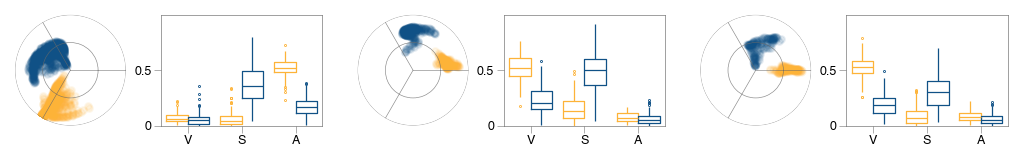

In [62]:
from matplotlib.gridspec import GridSpec
plt.rcParams["font.family"] = "Helvetica"

cm = 1/2.54
fig=plt.figure(figsize=(18*cm, 3*cm), dpi=150, facecolor='white')
gs = GridSpec(1, 6, figure=fig)

axs = [None] * 6
axs[0] = fig.add_subplot(gs[0,0], projection='polar')
axs[1] = fig.add_subplot(gs[0,2], projection='polar')
axs[2] = fig.add_subplot(gs[0,4], projection='polar')
axs[3] = fig.add_subplot(gs[0,1])
axs[4] = fig.add_subplot(gs[0,3])
axs[5] = fig.add_subplot(gs[0,5])

for i in range(3):
    axs[i].scatter(th_grp_rs_s[:32492][clsLH==1+i], rd_grp_rs_s[:32492][clsLH==1+i], c='#105186', alpha=.1, s=10)
    axs[i].scatter(th_grp_mv_s[:32492][clsLH==1+i], rd_grp_mv_s[:32492][clsLH==1+i], c='#FDB338', alpha=.1, s=10)
    axs[i].set_ylim([0,1])
    axs[i].set_yticks([0.5, 1])
    axs[i].set_xticks([0/360*2*np.pi,120/360*2*np.pi,240/360*2*np.pi])
    axs[i].set_xticklabels(labels=['','',''], fontdict={'fontsize':6, "color":'dimgrey'})
    axs[i].set_yticklabels(labels=['', ''], fontdict={'fontsize':6, "color":'dimgrey'})
    axs[i].set_rlabel_position(-45.5)
    axs[i].tick_params(axis='x', which='major', pad=-4.5)
    axs[i].grid(linewidth=.3, color='dimgrey', alpha=.8)
    axs[i].spines['polar'].set_visible(False)

sns.boxplot(df_l, x='type', y='beta_c1_l', hue='group', palette={'rs':'#105186','mv':'#FDB338'}, showcaps=False, showfliers=True, ax=axs[3], fill=False, legend=False, fliersize=.4, linewidth=.6)
sns.boxplot(df_l, x='type', y='beta_c2_l', hue='group', palette={'rs':'#105186','mv':'#FDB338'}, showcaps=False, showfliers=True, ax=axs[4], fill=False, legend=False, fliersize=.4, linewidth=.6)
sns.boxplot(df_l, x='type', y='beta_c3_l', hue='group', palette={'rs':'#105186','mv':'#FDB338'}, showcaps=False, showfliers=True, ax=axs[5], fill=False, legend=False, fliersize=.4, linewidth=.6)

for j in range(3,6):
    axs[j].set_xlabel('')
    axs[j].set_ylabel('')
    axs[j].set_xticklabels(labels=['V','S','A'], fontdict={'fontsize':6})
    axs[j].set_ylim([0,1])
    axs[j].set_yticks([0,.5])
    axs[j].set_yticklabels(labels=['0','0.5'], fontdict={'fontsize':6})
    axs[j].tick_params(axis='x', which='major', pad=1, color='grey', width=.3)
    axs[j].tick_params(axis='y', which='major', pad=1, color='grey', width=.3)
    for pos in ['top', 'bottom', 'left', 'right']:
        axs[j].spines[pos].set_linewidth(.3)
        axs[j].spines[pos].set_edgecolor('dimgrey')


plt.tight_layout(w_pad=-.8)
fig.savefig('/Users/weiwei/BaiduCloud/Work/Paris/HSV/Revised/figures/plot/f06/betas_LH_final.pdf', transparent=True)

/var/folders/_x/zn4_b1h54dn55qg4m99bn_y40000gn/T/ipykernel_14414/3297787064.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[j].set_xticklabels(labels=['V','S','A'], fontdict={'fontsize':6})


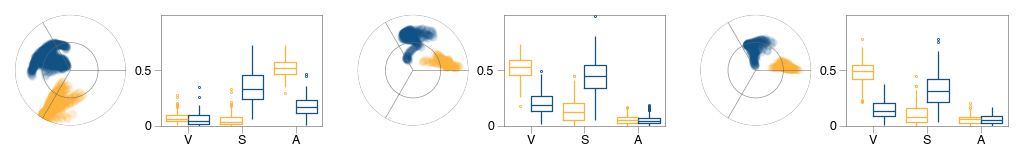

In [63]:
from matplotlib.gridspec import GridSpec
plt.rcParams["font.family"] = "Helvetica"

cm = 1/2.54
fig=plt.figure(figsize=(18*cm, 3*cm), dpi=150, facecolor='white')
gs = GridSpec(1, 6, figure=fig)

axs = [None] * 6
axs[0] = fig.add_subplot(gs[0,0], projection='polar')
axs[1] = fig.add_subplot(gs[0,2], projection='polar')
axs[2] = fig.add_subplot(gs[0,4], projection='polar')
axs[3] = fig.add_subplot(gs[0,1])
axs[4] = fig.add_subplot(gs[0,3])
axs[5] = fig.add_subplot(gs[0,5])

for i in range(3):
    axs[i].scatter(th_grp_rs_s[32492:][clsRH==1+i], rd_grp_rs_s[32492:][clsRH==1+i], c='#105186', alpha=.1, s=10)
    axs[i].scatter(th_grp_mv_s[32492:][clsRH==1+i], rd_grp_mv_s[32492:][clsRH==1+i], c='#FDB338', alpha=.1, s=10)
    axs[i].set_ylim([0,1])
    axs[i].set_yticks([0.5, 1])
    axs[i].set_xticks([0/360*2*np.pi,120/360*2*np.pi,240/360*2*np.pi])
    axs[i].set_xticklabels(labels=['','',''], fontdict={'fontsize':6, "color":'dimgrey'})
    axs[i].set_yticklabels(labels=['', ''], fontdict={'fontsize':6, "color":'dimgrey'})
    axs[i].set_rlabel_position(-45.5)
    axs[i].tick_params(axis='x', which='major', pad=-4.5)
    axs[i].grid(linewidth=.3, color='dimgrey', alpha=.8)
    axs[i].spines['polar'].set_visible(False)

sns.boxplot(df_r, x='type', y='beta_c1_r', hue='group', palette={'rs':'#105186','mv':'#FDB338'}, showcaps=False, showfliers=True, ax=axs[3], fill=False, legend=False, fliersize=.4, linewidth=.6)
sns.boxplot(df_r, x='type', y='beta_c2_r', hue='group', palette={'rs':'#105186','mv':'#FDB338'}, showcaps=False, showfliers=True, ax=axs[4], fill=False, legend=False, fliersize=.4, linewidth=.6)
sns.boxplot(df_r, x='type', y='beta_c3_r', hue='group', palette={'rs':'#105186','mv':'#FDB338'}, showcaps=False, showfliers=True, ax=axs[5], fill=False, legend=False, fliersize=.4, linewidth=.6)

for j in range(3,6):
    axs[j].set_xlabel('')
    axs[j].set_ylabel('')
    axs[j].set_xticklabels(labels=['V','S','A'], fontdict={'fontsize':6})
    axs[j].set_ylim([0,1])
    axs[j].set_yticks([0,.5])
    axs[j].set_yticklabels(labels=['0','0.5'], fontdict={'fontsize':6})
    axs[j].tick_params(axis='x', which='major', pad=1, color='grey', width=.3)
    axs[j].tick_params(axis='y', which='major', pad=1, color='grey', width=.3)
    for pos in ['top', 'bottom', 'left', 'right']:
        axs[j].spines[pos].set_linewidth(.3)
        axs[j].spines[pos].set_edgecolor('dimgrey')


plt.tight_layout(w_pad=-.8)
fig.savefig('/Users/weiwei/BaiduCloud/Work/Paris/HSV/Revised/figures/plot/f06/betas_RH_final.pdf', transparent=True)

In [24]:
rgba_mv_c1 = rgba_mv[:,:3,cls_use==1].mean(axis=2)
rgba_mv_c2 = rgba_mv[:,:3,cls_use==2].mean(axis=2)
rgba_mv_c3 = rgba_mv[:,:3,cls_use==3].mean(axis=2)
rgba_rs_c1 = rgba_rs[:,:3,cls_use==1].mean(axis=2)
rgba_rs_c2 = rgba_rs[:,:3,cls_use==2].mean(axis=2)
rgba_rs_c3 = rgba_rs[:,:3,cls_use==3].mean(axis=2)

df = pd.DataFrame({'beta_c1': np.concatenate((rgba_mv_c1[:,0], rgba_mv_c1[:,1], rgba_mv_c1[:,2], rgba_rs_c1[:,0], rgba_rs_c1[:,1], rgba_rs_c1[:,2])),
                   'beta_c2': np.concatenate((rgba_mv_c2[:,0], rgba_mv_c2[:,1], rgba_mv_c2[:,2], rgba_rs_c2[:,0], rgba_rs_c2[:,1], rgba_rs_c2[:,2])),
                   'beta_c3': np.concatenate((rgba_mv_c3[:,0], rgba_mv_c3[:,1], rgba_mv_c3[:,2], rgba_rs_c3[:,0], rgba_rs_c3[:,1], rgba_rs_c3[:,2])),
                    'group':['mv']*167*3 + ['rs']*167*3, 'type':(['V']*167+['S']*167+['A']*167) * 2})

df

,beta_c1,beta_c2,beta_c3,group,type
0,0.061900,0.582953,0.576488,mv,V
1,0.029270,0.620229,0.536762,mv,V
2,0.092137,0.465439,0.459453,mv,V
3,0.102801,0.621595,0.515846,mv,V
4,0.112457,0.635109,0.519219,mv,V
...,...,...,...,...,...
997,0.261424,0.199315,0.178823,rs,A
998,0.058550,0.015537,0.003797,rs,A
999,0.341582,0.038502,0.142733,rs,A
1000,0.166011,0.022180,0.029737,rs,A


/var/folders/_x/zn4_b1h54dn55qg4m99bn_y40000gn/T/ipykernel_14414/1043218603.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[j].set_xticklabels(labels=['V','S','A'], fontdict={'fontsize':6})


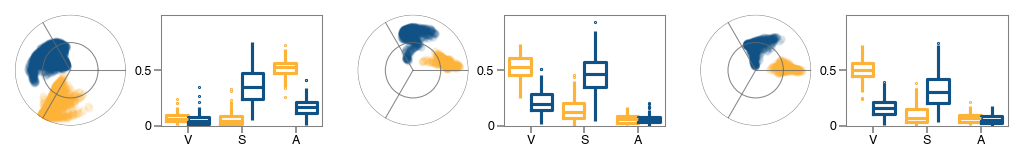

In [25]:
cm = 1/2.54
fig=plt.figure(figsize=(18*cm, 3*cm), dpi=150, facecolor='white')
gs = GridSpec(1, 6, figure=fig)

axs = [None] * 6
axs[0] = fig.add_subplot(gs[0,0], projection='polar')
axs[1] = fig.add_subplot(gs[0,2], projection='polar')
axs[2] = fig.add_subplot(gs[0,4], projection='polar')
axs[3] = fig.add_subplot(gs[0,1])
axs[4] = fig.add_subplot(gs[0,3])
axs[5] = fig.add_subplot(gs[0,5])

for i in range(3):
    axs[i].scatter(th_grp_rs[cls_use==1+i], rd_grp_rs[cls_use==1+i], c='#105186', alpha=.1, s=10)
    axs[i].scatter(th_grp_mv[cls_use==1+i], rd_grp_mv[cls_use==1+i], c='#FDB338', alpha=.1, s=10)
    axs[i].set_ylim([0,1])
    axs[i].set_yticks([0.5, 1])
    axs[i].set_xticks([0/360*2*np.pi,120/360*2*np.pi,240/360*2*np.pi])
    axs[i].set_xticklabels(labels=['','',''], fontdict={'fontsize':6, "color":'dimgrey'})
    axs[i].set_yticklabels(labels=['', ''], fontdict={'fontsize':6, "color":'dimgrey'})
    axs[i].set_rlabel_position(-45.5)
    axs[i].tick_params(axis='x', which='major', pad=-4.5)
    axs[i].grid(linewidth=.5, color='dimgrey', alpha=.8)
    axs[i].spines['polar'].set_visible(False)

sns.boxplot(df, x='type', y='beta_c1', hue='group', palette={'rs':'#105186','mv':'#FDB338'}, showcaps=False, showfliers=True, ax=axs[3], fill=False, legend=False, fliersize=.5)
sns.boxplot(df, x='type', y='beta_c2', hue='group', palette={'rs':'#105186','mv':'#FDB338'}, showcaps=False, showfliers=True, ax=axs[4], fill=False, legend=False, fliersize=.5)
sns.boxplot(df, x='type', y='beta_c3', hue='group', palette={'rs':'#105186','mv':'#FDB338'}, showcaps=False, showfliers=True, ax=axs[5], fill=False, legend=False, fliersize=.5)

for j in range(3,6):
    axs[j].set_xlabel('')
    axs[j].set_ylabel('')
    axs[j].set_xticklabels(labels=['V','S','A'], fontdict={'fontsize':6})
    axs[j].set_ylim([0,1])
    axs[j].set_yticks([0,.5])
    axs[j].set_yticklabels(labels=['0','0.5'], fontdict={'fontsize':6})
    axs[j].tick_params(axis='x', which='major', pad=1, color='grey')
    axs[j].tick_params(axis='y', which='major', pad=1, color='grey')
    for pos in ['top', 'bottom', 'left', 'right']:
        axs[j].spines[pos].set_linewidth(.5)
        axs[j].spines[pos].set_edgecolor('grey')


plt.tight_layout(w_pad=-.8)

In [ ]:
fig.savefig('/Users/weiwei/BaiduCloud/Work/Paris/HSV/Revised/figures/plot/f06/betas_final.pdf', transparent=True)

In [7]:
# rd_mv_c1 = rd_grp_mv[cls_use==1]
# rd_rs_c1 = rd_grp_rs[cls_use==1]
# rd_mv_c2 = rd_grp_mv[cls_use==2]
# rd_rs_c2 = rd_grp_rs[cls_use==2]
# rd_mv_c3 = rd_grp_mv[cls_use==3]
# rd_rs_c3 = rd_grp_rs[cls_use==3]

th_mv_c1 = th_grp_mv[cls_use==1]
th_rs_c1 = th_grp_rs[cls_use==1]
th_mv_c2 = th_grp_mv[cls_use==2]
th_rs_c2 = th_grp_rs[cls_use==2]
th_mv_c3 = th_grp_mv[cls_use==3]
th_rs_c3 = th_grp_rs[cls_use==3]

In [10]:
import pycircstat as circ
print(circ.descriptive.mean(th_mv_c1)*360/(2*np.pi), circ.descriptive.mean(th_rs_c1)*360/(2*np.pi))
print(circ.descriptive.mean(th_mv_c2)*360/(2*np.pi), circ.descriptive.mean(th_rs_c2)*360/(2*np.pi))
print(circ.descriptive.mean(th_mv_c3)*360/(2*np.pi), circ.descriptive.mean(th_rs_c3)*360/(2*np.pi))

243.36718891069927 145.26150721313098
13.625006368469647 93.80027832117372
4.92836173875543 90.21547835553703


In [12]:
display(ss.ttest_rel(rgba_mv_c1, rgba_rs_c1))
display(ss.ttest_rel(rgba_mv_c2, rgba_rs_c2))
display(ss.ttest_rel(rgba_mv_c3, rgba_rs_c3))

TtestResult(statistic=array([  3.25397046, -26.74700158,  45.09530787]), pvalue=array([1.37902961e-03, 4.52344110e-62, 4.59960084e-95]), df=array([166, 166, 166]))

TtestResult(statistic=array([ 31.33391058, -24.18161279,   1.12177151]), pvalue=array([1.33153926e-71, 2.80286770e-56, 2.63579637e-01]), df=array([166, 166, 166]))

TtestResult(statistic=array([ 38.23590948, -17.93098442,   2.70577015]), pvalue=array([3.28311328e-84, 1.11143359e-40, 7.52624938e-03]), df=array([166, 166, 166]))

In [24]:
import pycircstat as circ

for i in range(3):
    th_mv_l = th_grp_mv_s[:32492][clsLH==i+1]
    th_mv_r = th_grp_mv_s[32492:][clsRH==i+1]
    th_rs_l = th_grp_rs_s[:32492][clsLH==i+1]
    th_rs_r = th_grp_rs_s[32492:][clsRH==i+1]
    print('L-mv: '+ str(np.round(circ.descriptive.mean(th_mv_l)*360/(2*np.pi),1)), 'L-rs: '+ str(np.round(circ.descriptive.mean(th_rs_l)*360/(2*np.pi),1)))
    print('R-mv: '+ str(np.round(circ.descriptive.mean(th_mv_r)*360/(2*np.pi),1)), 'R-rs: '+ str(np.round(circ.descriptive.mean(th_rs_r)*360/(2*np.pi),1)))

L-mv: 242.2 L-rs: 143.5
R-mv: 244.7 R-rs: 147.3
L-mv: 12.9 L-rs: 92.9
R-mv: 14.3 R-rs: 94.6
L-mv: 1.2 L-rs: 84.9
R-mv: 7.8 R-rs: 94.1


In [23]:
print(ss.ttest_rel(rgba_mv_c1_l, rgba_rs_c1_l))
print(ss.ttest_rel(rgba_mv_c2_l, rgba_rs_c2_l))
print(ss.ttest_rel(rgba_mv_c3_l, rgba_rs_c3_l))
print(ss.ttest_rel(rgba_mv_c1_r, rgba_rs_c1_r))
print(ss.ttest_rel(rgba_mv_c2_r, rgba_rs_c2_r))
print(ss.ttest_rel(rgba_mv_c3_r, rgba_rs_c3_r))

TtestResult(statistic=array([  2.70291041, -26.53253491,  45.0870727 ]), pvalue=array([7.58849991e-03, 1.33810894e-61, 4.73041025e-95]), df=array([166, 166, 166]))
TtestResult(statistic=array([ 27.07331527, -23.84351468,   2.48318753]), pvalue=array([8.77652494e-63, 1.72629237e-55, 1.40146153e-02]), df=array([166, 166, 166]))
TtestResult(statistic=array([ 36.75312767, -17.44531974,   4.49519225]), pvalue=array([1.16999805e-81, 2.20396577e-39, 1.29926474e-05]), df=array([166, 166, 166]))
TtestResult(statistic=array([  3.56129237, -25.69735843,  40.73668833]), pvalue=array([4.81722607e-04, 9.62612103e-60, 2.43441135e-88]), df=array([166, 166, 166]))
TtestResult(statistic=array([ 33.06728552, -23.35905222,  -0.42664907]), pvalue=array([5.96510397e-75, 2.39451872e-54, 6.70187743e-01]), df=array([166, 166, 166]))
TtestResult(statistic=array([ 36.34218223, -17.58113852,   0.9284818 ]), pvalue=array([6.16220125e-81, 9.53416860e-40, 3.54505809e-01]), df=array([166, 166, 166]))
